# **Brain Tumor Detection**

##[Table of Contents](#scrollTo=8T_ecJBW424A)

>[1. Initial Setup](#scrollTo=uTM6ykhI44qt)

>[2. Preprocessing](#scrollTo=z7g137-I478t)

>>[2.1. Balancing](#scrollTo=SkMYJOLx0lFA)

>>[2.1. Creating the Datasets](#scrollTo=cd68cf37)

>>[2.2. Visualizing Instances](#scrollTo=uClYKkV15XA2)

>[3. Machine Learning](#scrollTo=Jn1psqiC5cyA)

>>[3.1. Sandbox CNN](#scrollTo=SImo3_U1iC1H)

>>>[3.1.1. Metrics and Base Model](#scrollTo=hAJM_b-0cFk8)

>>>[3.1.2. Data Formatting](#scrollTo=WfUEan9efAC2)

>>>[3.1.3. Defining Callbacks, Training and Evaluating](#scrollTo=Fdjj6OMbfIZ0)

>>>[3.1.4. Visual Results](#scrollTo=TkT-PDkqfSzL)

>>[3.2. YOLOv8 Model](#scrollTo=P7REUtL-lNGw)

>>>[3.2.1. Training Process](#scrollTo=a01LzAeO5iLV)

>[4. Analyzing Results](#scrollTo=6b534df0)

>>[Losses](#scrollTo=jdPkLeqcBCA4)

>>[Learning Rate](#scrollTo=rCulIQnbBGk2)

>>[mAP](#scrollTo=2ac28vZnBJGi)

>>[mAP - Area](#scrollTo=ofeXRCWCBMzg)

>>[Recall](#scrollTo=WhkbJArnBRne)

>>[Recall - Area](#scrollTo=tP5qVTApBQGX)

>>[4.1. Prediction Testing](#scrollTo=ee41aa19)



# **1. Initial Setup**

- Downloading the dataset from Google Drive;

- Defining some constants;

- Mapping classes.

In [1]:
!pip install --upgrade -q gdown

from warnings import filterwarnings
from gdown    import download
from os.path  import isdir
from os       import (getcwd,
                      mkdir)

output_file = 'dataset.zip'
file_id = '18cPvbZrH5CUWhhIGZOSkiBSnCA0GPC1z'
download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=True)

!unzip -o -q ./{output_file} -d .

# TODO: Better warnings filtering
filterwarnings('ignore')

# Figures export directory
if not isdir(f'{getcwd()}/plots'):
    mkdir(f'{getcwd()}/plots')

In [2]:
BATCH_SIZE = 32
HEIGHT, WIDTH = 132, 139
ACTV_FUNC = 'relu'
BBOX_FORMAT = 'xyxy'

- PS: We're only detecting tumours for now.

In [3]:
class_ids = ['Glioma', 'Meningioma', 'Metastatic']
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'Glioma', 1: 'Meningioma', 2: 'Metastatic'}

# **2. Preprocessing**

- Parsing each _.txt_ file containing the tumours locations and its type (if it is present);

- Arrange each image in tensors, containing the image path, tumours types and its locations;

- Necessary steps for feeding the machine learning model.

In [4]:
import cv2 as cv


def parse_txt_label(img_path: str, txt_path: str) -> tuple[list, list]:

    img = cv.imread(img_path)
    width, height = img.shape[0], img.shape[1]

    instance_file = open(txt_path, 'r')
    lines = instance_file.read().split('\n')

    boxes, classes = list(), list()

    # No tumour case
    if not lines[0]:
        return classes, boxes
    else:
        for line in lines:

            # Structure for each line in txt file: <label> <center_x> <center_y> <width> <height>
            tumour = line.split(' ')
            label = int(tumour[0])

            # Box center (x, y) and its dimensions (width and height)
            x = float(tumour[1])
            y = float(tumour[2])
            w = float(tumour[3])
            h = float(tumour[4])

            # The coords are also normalized between [0, 1], needing conversion
            xmin = int((x * width) - (w * width) / 2.0)
            ymin = int((y * height) - (h * height) / 2.0)
            xmax = int((x * width) + (w * width) / 2.0)
            ymax = int((y * height) + (h * height) / 2.0)

            boxes.append([xmin, ymin, xmax, ymax])
            classes.append(label)

    return classes, boxes

## **2.1. Balancing**

- Since we have imbalance both in tumours quantity and its types, we'll try to balance the dataset with a simple random oversampling technique (i.e., duplicating random images from a type);

- As shown in the EDA, images with 3 tumours correspond to more than half of the dataset, while non-tumourous images only represent 1.14%.

- Each scan can have multiple tumours from different types, therefore, it isn't possible to perfect balance both aspects of the dataset (quantity and classes);

- For instance, consider we have 5 images with all 3 tumours, 3 images with 1 tumour (one of each type) and 2 images without tumours. For quantity balancing, we could start by duplicating non tumourous images until we reach 5 of them. However, we also need to duplicate the images with only one tumour to reach 5. By doing this, we would raise the number of classes from each tumour, and consequently need to duplicate non tumourous images again (i.e., infinite loop).

- Thus, we're only balancing the dataset based on number of tumours, since we are only detecting them. However, it's also possible to balance it by classes and perform some random undersampling in it, since we implemented those funcionalities in case of need;

- The overall balancing is done by constructing a _.csv_ file with information about the images (facilitating the use of Python libs). In the end, we only return a list containing file names from each image (oversampled dataset);

- The class balancing works by constructing an auxiliary column that corresponds to each possible tumours combinations (type and quantity). That way, we duplicate all of them to match the majority one (equaling the amount of each type) and them also perform it with non-tumourous images. However, as said earlier, applying this doesn't balance the number of tumours by image, with the ones which have 3 tumours being the least representative in the dataset.

- It's important to note that the undersampling technique is poorly implemented (randomly deleting images), and could lead to deterioration of the model. Better alternatives could be applting _instance selection_ (removing "redundant" images without impacting the model's performance) or a targeted oversampling to match the desired dataset size.

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from os.path                 import isfile
from os                      import listdir
import pandas as pd


def balance_dataset(label_files_path: str, quantity: bool=True, threshold: float=0.0):

    instances = list()
    correspondences = {0: 'Glioma', 1: 'Meningioma', 2: 'Metastatic'}

    # Construction of the images table for balancing based on quantity of tumours and types
    for filename in listdir(label_files_path):
        if filename.endswith('.txt'):

            label_path = join(label_files_path, filename)

            if isfile(label_path):

                each_instance = pd.DataFrame(columns=['Glioma', 'Meningioma', 'Metastatic', 'No Tumour'])
                label_counts = dict()
                total_count = 0

                with open(label_path, 'r') as label_file:

                    for line in label_file:

                        # Split the line into label and coordinates
                        label = line.strip().split()[0]
                        label_name = correspondences[int(label)]

                        # Increments the label count
                        label_counts[label] = label_counts.get(label, 0) + 1
                        each_instance[label_name] = [label_counts[label]]
                        total_count += 1

                if total_count == 0:
                    each_instance['No Tumour'] = [1]

                # If the instance doesn't have all labels
                each_instance = each_instance.fillna(0)

                each_instance['File Name'] = filename.replace('.txt', '.jpg')
                each_instance['Total'] = total_count
                instances.append(each_instance)

    unbalanced_df = pd.concat(instances, ignore_index=True)

    # Balances number of tumours by image
    if quantity:
        attributes = unbalanced_df.drop(['Total'], axis='columns')
        classes = unbalanced_df['Total']

        oversampler = RandomOverSampler(sampling_strategy='not majority')
        balanced_df, post_balance = oversampler.fit_resample(attributes, classes)

        print(f'Before balancing:\n{unbalanced_df["Total"].value_counts()}\n')
        print(f'After balancing:\n{post_balance.value_counts()}')

    # Balance classes proportion
    else:
        # All combined triples {(0, 0, 1), (0, 1, 0), (0, 1, 1), ..., (1, 1, 1)}
        unbalanced_df['Combinations'] = unbalanced_df[['Glioma', 'Meningioma', 'Metastatic']].apply(lambda row: '_'.join(map(str, row)), axis=1)
        attributes = unbalanced_df.drop(['Combinations'], axis='columns')
        classes = unbalanced_df['Combinations']

        # Oversamples images which have tumour (minority classes)
        class_oversampler = RandomOverSampler(sampling_strategy='not majority')
        attributes, _ = class_oversampler.fit_resample(attributes.copy(), classes)

        classes = attributes['No Tumour']
        attributes = attributes.drop(['No Tumour'], axis='columns')

        # Oversamples images which don't have tumour
        absence_oversampler = RandomOverSampler(sampling_strategy={1: attributes['Glioma'].sum()})
        balanced_df, balanced_cls = absence_oversampler.fit_resample(attributes.copy(), classes.copy())
        balanced_df['No Tumour'] = balanced_cls

        # Eventual undersampling if necessary (e.g., execution time)
        if threshold > 0:
            # All combined quadruples {(0, 0, 0, 1), (0, 0, 1, 0), ..., (1, 1, 1, 0)}
            combinations = balanced_df[['Glioma', 'Meningioma', 'Metastatic', 'No Tumour']].apply(lambda row: '_'.join(map(str, row)), axis=1)
            desired_reduction = (combinations.value_counts() * threshold).astype(int)
            sampling_strategy = dict(desired_reduction)

            undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
            balanced_df, _ = undersampler.fit_resample(balanced_df.copy(), combinations)

    return list(balanced_df['File Name'])

In [6]:
from os.path import join
import tensorflow as tf


def arranging_files(img_files_path: str, label_files_path: str, balance: bool=False) -> tuple[list, list, list]:

    img_list, image_paths, bounding_box, classes = list(), list(), list(), list()

    if balance:
        img_list = balance_dataset(label_files_path=label_files_path)
    else:
        img_list = listdir(img_files_path)

    for img_file in img_list:

        labels, bbox = parse_txt_label(img_path=f'{img_files_path}/{img_file}',
                                       txt_path=f'{label_files_path}/{img_file.replace(".jpg", ".txt")}')

        image_paths.append(join(img_files_path, img_file))
        classes.append(labels)
        bounding_box.append(bbox)

    # Constructs RaggedTensors from nested Python lists
    image_paths = tf.ragged.constant(image_paths)
    bounding_box = tf.ragged.constant(bounding_box)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bounding_box

In [7]:
train_img_paths, train_classes, train_bboxes = arranging_files(img_files_path='Brain Tumor Detection/train/images',
                                                               label_files_path='Brain Tumor Detection/train/labels',
                                                               balance=True)

valid_img_paths, valid_classes, valid_bboxes = arranging_files(img_files_path='Brain Tumor Detection/valid/images',
                                                               label_files_path='Brain Tumor Detection/valid/labels')

test_img_paths, test_classes, test_bboxes = arranging_files(img_files_path='Brain Tumor Detection/test/images',
                                                            label_files_path='Brain Tumor Detection/test/labels')

Before balancing:
Total
3    3525
1    2186
2    1140
0      79
Name: count, dtype: int64

After balancing:
Total
1    3525
3    3525
2    3525
0    3525
Name: count, dtype: int64


## **2.1. Creating the Datasets**

In [8]:
def img_preprocessing(img_path):

    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # img = tf.cast(img, tf.float32)
    img = tf.cast(img, tf.float32) / 255.0

    return img


def load_dataset(img_paths, classes, bbox):

    img = img_preprocessing(img_paths)

    bounding_boxes = {'classes': tf.cast(classes, dtype=tf.float32),
                      'boxes': bbox }

    return {'images': img, 'bounding_boxes': bounding_boxes}


def dict_to_tuple(inputs):
    return inputs['images'], inputs['bounding_boxes']

- Until now, YOLO only accepts images with dimensions above 128 and that are multiple of 64 (need to investigate more about this);

- No augmentation is being applied for now, just drafting some random noise introduction in the training dataset:
    - Scaling the resolution of images from [(128, 128), (192, 192)];

    - Applying horizontal mirrowing;

    - Lowering and raising constrast (needs tuning);

    - Lowering and raising brightness (needs tuning).

- The datasets pass the following stages:
    - Loading the images, tumour classes its locations in sliced tensors;
    
    - Creation of batches (32 images each);
    
    - Resizing images maintaining aspect ratio.

- The training dataset is also shuffled and can pass through some augmenting layers to introduce noise, aiming to reduce overfitting.


In [9]:
!pip install -q keras_cv

from keras import Sequential
from keras_cv.layers import (JitteredResize,
                             Resizing,
                             RandomFlip,
                             RandomContrast,
                             RandomBrightness)


# Option for automatically define best level of parallelism and dataset processing
AUTO = tf.data.AUTOTUNE

# Resizes all images maintaining aspect ratio (no flattening or stretching)
resizing = Resizing(height=192, width=192, pad_to_aspect_ratio=True,
                    bounding_box_format=BBOX_FORMAT)

# Augmenting layers to perform data augmentation on the dataset
# PS: If using this, apply only on the training set (careful with jresize - RAM usage)
augmenter = Sequential(
    layers=[
        # JitteredResize(target_size=(128, 128), scale_factor=(1, 1.5), bounding_box_format=BBOX_FORMAT),
        RandomFlip(mode='horizontal', bounding_box_format=BBOX_FORMAT),
        RandomContrast(factor=0.5, value_range=[0.0, 255.0]),
        RandomBrightness(factor=0.5, value_range=[0.0, 255.0])
    ]
)

# Arranges the data in tensor slices (necessary for inputing the model)
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))

# Loads all data, shuffles it, make batches, introduce noise and resizes the images
train_dataset = (train_loader
                 .map(load_dataset, num_parallel_calls=AUTO)
                 .shuffle(len(list(train_loader.as_numpy_iterator())))
                 .ragged_batch(BATCH_SIZE)
                 # .map(augmenter,num_parallel_calls=tf.data.AUTOTUNE)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls=AUTO)
                 .prefetch(AUTO))

valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_dataset, num_parallel_calls=AUTO)
                 .ragged_batch(BATCH_SIZE)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls=AUTO)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_dataset, num_parallel_calls=AUTO)
                .ragged_batch(BATCH_SIZE)
                .map(resizing, num_parallel_calls=AUTO)
                .map(dict_to_tuple, num_parallel_calls=AUTO)
                .prefetch(AUTO))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.1 MB/s eta 0:00:00
Using TensorFlow backend


## **2.2. Visualizing Instances**

In [10]:
from keras_cv.visualization import plot_bounding_box_gallery


# Visualize example images along wih classes and boxes
def visualize_dataset(inputs: any, value_range: tuple, rows: int, cols: int, bounding_box_format: str) -> None:

    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    plot_bounding_box_gallery(images, value_range=value_range,
                              rows=rows, cols=cols,
                              y_true=bounding_boxes, scale=4,
                              font_scale=0.8, line_thickness=2,
                              dpi=100, bounding_box_format=bounding_box_format,
                              # class_mapping=class_mapping,
                              true_color=(192, 57, 43))

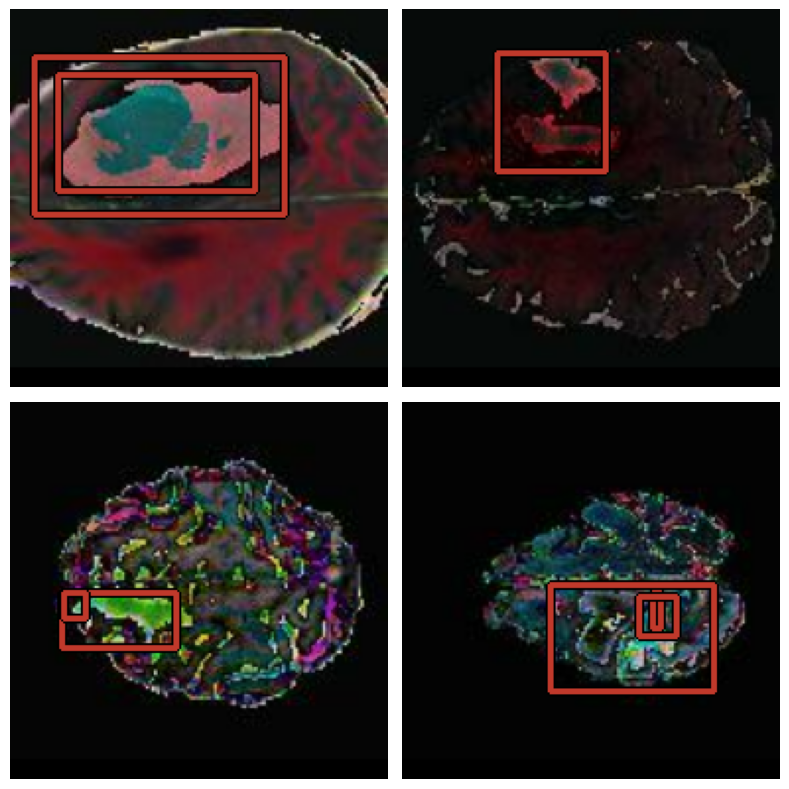

In [ ]:
visualize_dataset(inputs=train_dataset, value_range=(0, 255), rows=2, cols=2, bounding_box_format=BBOX_FORMAT)

# **3. Machine Learning**

## **3.1. Sandbox CNN**

- Since using a state of the art model requires more computational power and time, we built a simple CNN to perform some experiments with the dataset;

- By using a simpler model, we can test a higher amount of changes in less time (e.g., preprocessing techniques, DIP, hyperparameters, ...) to evaluate their benefits in the model's performance. If it becomes benefitial, we can then apply those on the "definitive" model and discard others that haven't shown good results;

- That way, we can reduce by a reasonable amount, the total time spent building the whole model.

![CNN](https://i.ibb.co/WktNrSG/gec2.jpg)

- About the CNN architecture:

    - **Convolutional Layer** (Conv2D): Extracts N filter maps (based on the number of filters) using a weighted feature detector (i.e., 2D matrix or kernel) that sweeps across the entire image performing element wise multiplications. In this case, it's used _same_ padding, which indicates that the output layer has the same size as the input layer (information preservation);

    ![Conv](https://i.ibb.co/L02sZ85/gec.jpg)

    - **Pooling Layer** (MaxPool2D): Acts as a downsampler performing dimensionality reduction. A, unweighted filter sweeps across the image, in this case selecting pixels which have the maximum value in the neighborhood (i.e., kernel size);

    ![MaxPool](https://i.ibb.co/NnDxRKp/maxpool.jpg)

    - **Dropout**: A regularization method where a proportion of nodes in the layer are randomly ignored for each training sample. This may force the network to learn features in a distributed way, also improving generalization and reducing overfitting.

    ![Dropout](https://i.ibb.co/Z63Kftm/dropout.jpg)

    - **Batch Normalization**: Technique that improves training stability and accelerates convergence, normalizing the activations of each layer. It also adds some noise to each layer during training, acting as a form of regularization like _dropout_. It's often used after convolution and leads to better generalization on unseen data.

    - The dense layers are, in graph terminology, fully connected, which means that each neuron is connected with every other neuron from the previous and successor layers. However, since we're dealing with a feedforward NN, it can be visualized as a directed acyclic graph (i.e., information only travels forward through the nodes and cannot "go back" to previous ones);

    - The activation function used through all the CNN layers is ReLU (Rectified Linear Unit), which is used to add non-linearity to the network, since images are non-linear. Also, the use of convolutional and pooling layers often reduces the computational cost on fitting the model (dimensionality reduction), compared to simpler MLPs.

In [ ]:
from keras.losses import Loss


class CIoU(Loss):

    def __init__(self, lambda_coord: float=5.0, lambda_noobj: float=0.5) -> None:
        super(CIoU, self).__init__()
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    @staticmethod
    def __calculate_iou(true_box, pred_box) -> float:

        # Calculate intersection coordinates
        intersect_top_left = tf.maximum(true_box[..., :2], pred_box[..., :2])
        intersect_bottom_right = tf.minimum(true_box[..., :2] + true_box[..., 2:], pred_box[..., :2] + tf.exp(pred_box[..., 2:]))

        # Calculate intersection area
        intersect_wh = tf.maximum(intersect_bottom_right - intersect_top_left, 0.0)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

        # Calculate true box and predicted box areas
        true_area = true_box[..., 2] * true_box[..., 3]
        pred_area = tf.exp(pred_box[..., 2]) * tf.exp(pred_box[..., 3])

        # Calculate union area
        union_area = true_area + pred_area - intersect_area

        # Calculate IoU
        iou = intersect_area / union_area

        return iou

    @staticmethod
    def __calculate_ciou_term(true_box, pred_box) -> float:

        # Calculate center points
        true_center = true_box[..., :2] + true_box[..., 2:] / 2.0
        pred_center = pred_box[..., :2] + tf.exp(pred_box[..., 2:]) / 2.0

        # Calculate diagonal distances
        true_diag = tf.sqrt(tf.reduce_sum(tf.square(true_box[..., 2:]), axis=-1))
        pred_diag = tf.sqrt(tf.reduce_sum(tf.square(tf.exp(pred_box[..., 2:])), axis=-1))

        # Calculate center distance
        center_distance = tf.reduce_sum(tf.square(true_center - pred_center), axis=-1)

        # Calculate aspect ratio consistency term
        aspect_ratio_term = tf.atan(true_box[..., 2] / true_box[..., 3]) - tf.atan(tf.exp(pred_box[..., 2]) / tf.exp(pred_box[..., 3]))
        aspect_ratio_term = tf.square(aspect_ratio_term) * (4 / (tf.math.pi ** 2))

        # Calculate ciou term
        ciou_term = center_distance / tf.maximum((true_diag + pred_diag), 1e-7) + aspect_ratio_term

        return ciou_term

    def call(self, ground_truth, predictions) -> float:
        # Calculates CIoU loss for bounding box regression
        # ground_truth: [batch_size, grid_size, grid_size, num_anchor_boxes, 5] (x, y, w, h, obj)
        # predictions: [batch_size, grid_size, grid_size, num_anchor_boxes, 5] (tx, ty, tw, th, obj)

        # Extract coordinates and objectness from ground_truth and predictions
        true_box, pred_box = ground_truth[..., :4], predictions[..., :4]
        obj_mask = tf.expand_dims(ground_truth[..., 4], axis=-1)

        # Calculate IoU and CIoU term
        iou = self.__calculate_iou(true_box, pred_box)
        ciou = iou - self.__calculate_ciou_term(true_box, pred_box)

        # Calculate CIoU loss
        ciou_loss = obj_mask * (1 - ciou)

        # Compute total loss
        total_loss = tf.reduce_mean(ciou_loss)

        return total_loss

### **3.1.1. Metrics and Base Model**

- Since _keras_ native support to metrics and losses is limited. we'll implement custom ones to evaluate the model, such as R² and CIoU;

- However, it's important to note that the CIoU loss still isn't working the intended way, and was also implemented with the help of _ChatGPT_;

- For now, we're using the following metrics to evaluate the model:

    - R² (a.k.a., Coefficient of Determination);

    - MAE (Mean Absolute Error).

- R² represents the data's percentage variance which is explained by the model. In other words, the greater R² value is, the more explanatory the model is in relation to predicted data. It's extremely simple to interpret, since it has  a well defined interval which it can assume [0, 1];

- MAE is a metric robust to outliers, that represents the average difference between predictions and ground truth. For instance, a MAE of 20 would indicate that on average, the absolute difference in pixel distance between the predicted bounding box and the real one is 20;

- Since we're detecting tumours, this CNN will have a major flaw: the **output**. It has a fixed amount of neurons, so we opted for modeling after the highest number of tumours by image found in the dataset;

- The output layer has 12 neurons, which every four correspond to a bounding box (detected tumour). Feeding this model with a brain scan that has 4 or more tumours to detect can be problematic, since one or more of them surely wouldn't be detected;

- However, this model will act only as our sandbox, that is, it won't be used as a final model under any circumstances.

In [ ]:
from keras        import backend
from keras.layers import (BatchNormalization,
                          MaxPooling2D,
                          Flatten,
                          Dropout,
                          Conv2D,
                          Dense)


def r2_score(ground_truth, predictions) -> float:

    ss_res = backend.sum(backend.square(ground_truth - predictions))
    ss_tot = backend.sum(backend.square(ground_truth - backend.mean(ground_truth)))

    return 1 - ss_res / (ss_tot + backend.epsilon())


def build_model(input_shape: tuple, num_tumours: int):

    model = Sequential()

    # 2 pairs: conv | norm | maxpool | dropout
    model.add(Conv2D(32, (3, 3), activation=ACTV_FUNC, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation=ACTV_FUNC))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation=ACTV_FUNC))
    model.add(BatchNormalization())

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(1024, activation=ACTV_FUNC))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation=ACTV_FUNC))
    model.add(Dropout(0.4))

    # Bounding boxes coordinates
    model.add(Dense(4 * num_tumours, activation='linear'))

    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[r2_score])
    return model

### **3.1.2. Data Formatting**

- We're feeding the CNN with images encoded as _numpy_ n-dimensional arrays normalized in the interval [0, 1];

- Absence of tumour is represented as a bounding box with -1 as all values (invalid image coordinates).

In [ ]:
import numpy as np


def cnn_format_df(images_path: str) -> tuple[list, list]:

    images, bounding_boxes = list(), list()
    img_files = listdir(join(images_path, 'images'))

    for scan in img_files:

        img = cv.imread(join(images_path, 'images', scan))
        width, height = img.shape[0], img.shape[1]
        images.append(img)

        instance_file = open(join(images_path, 'labels', scan.replace('.jpg', '.txt')), 'r')
        lines = instance_file.read().split('\n')

        boxes = list()

        # No tumour 'bounding box' is encoded as [-1, -1, -1, -1]
        if not lines[0]:
            boxes = [-1] * 12
        else:
            for line in lines:

                tumour = line.split(' ')

                x = float(tumour[1])
                y = float(tumour[2])
                w = float(tumour[3])
                h = float(tumour[4])

                xmin = int((x * width) - (w * width) / 2.0)
                ymin = int((y * height) - (h * height) / 2.0)
                xmax = int((x * width) + (w * width) / 2.0)
                ymax = int((y * height) + (h * height) / 2.0)

                boxes += [xmin, ymin, xmax, ymax]

            # Padding when there aren't 3 tumours
            boxes += [-1] * (12 - len(lines) * 4)

        bounding_boxes.append(boxes)

    return images, bounding_boxes


def reshape_data(data: list) -> np.ndarray:

    # Each image is flattened as 3 arrays (one for each color channel)
    reshaped_data = data.reshape(data.shape[0],
                                 data.shape[1] * data.shape[2],
                                 data.shape[3])

    # Normalizes pixels between 0 and 1
    data_attributes = reshaped_data.astype('float32') / 255
    reshaped_attributes = data_attributes.reshape(data.shape[0],
                                                  data.shape[1],
                                                  data.shape[2],
                                                  data.shape[3])

    return reshaped_attributes


training_images, training_boxes = cnn_format_df(images_path='Brain Tumor Detection/train')
validation_images, validation_boxes = cnn_format_df(images_path='Brain Tumor Detection/valid')

training_images, training_boxes = np.array(training_images), np.array(training_boxes)
validation_images, validation_boxes = np.array(validation_images), np.array(validation_boxes)

cnn_training_attributes = reshape_data(data=training_images)
cnn_validation_attributes = reshape_data(data=validation_images)

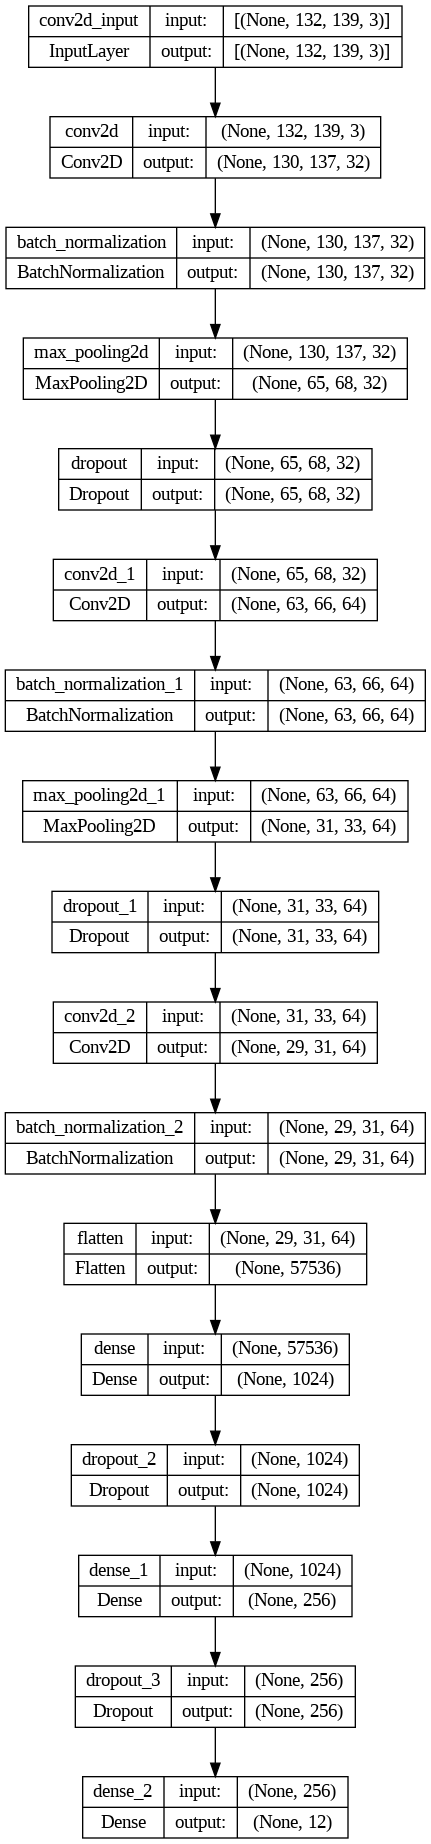

In [ ]:
from keras.utils import plot_model


sandbox_cnn = build_model((HEIGHT, WIDTH, 3), 3)
plot_model(sandbox_cnn, show_shapes=True)

### **3.1.3. Defining Callbacks, Training and Evaluating**

In [ ]:
from keras.callbacks import (ReduceLROnPlateau,
                             EarlyStopping)


# Decreases learning rate by half after each 3 epochs passed and no improvement was made
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                            patience=3, verbose=1, mode='min',
                                            min_lr=0.00001)

# Stop training if after 5 epochs passed no improvement was made
early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1,
                           mode='min', restore_best_weights=True)

sandbox_cnn.fit(cnn_training_attributes, training_boxes, epochs=30, batch_size=BATCH_SIZE,
                validation_data=(cnn_validation_attributes, validation_boxes),
                callbacks=[early_stop, learning_rate_reduction])

Epoch 1/30
217/217 [==============================] - 30s 96ms/step - loss: 28.6915 - r2_score: 0.2505 - val_loss: 35.5406 - val_r2_score: 0.0020 - lr: 0.0010
Epoch 2/30
217/217 [==============================] - 15s 68ms/step - loss: 22.9015 - r2_score: 0.4927 - val_loss: 72.6967 - val_r2_score: -3.2892 - lr: 0.0010
Epoch 3/30
217/217 [==============================] - 14s 67ms/step - loss: 19.9980 - r2_score: 0.5948 - val_loss: 24.7667 - val_r2_score: 0.3378 - lr: 0.0010
Epoch 4/30
217/217 [==============================] - 13s 61ms/step - loss: 18.0633 - r2_score: 0.6551 - val_loss: 18.2524 - val_r2_score: 0.6368 - lr: 0.0010
Epoch 5/30
217/217 [==============================] - 13s 60ms/step - loss: 16.6942 - r2_score: 0.6993 - val_loss: 18.9159 - val_r2_score: 0.5620 - lr: 0.0010
Epoch 6/30
217/217 [==============================] - 13s 61ms/step - loss: 15.8695 - r2_score: 0.7270 - val_loss: 17.8867 - val_r2_score: 0.6464 - lr: 0.0010
Epoch 7/30
217/217 [=========================

In [ ]:
test_images, test_boxes = cnn_format_df(images_path='Brain Tumor Detection/test')
test_images, test_boxes = np.array(test_images), np.array(test_boxes)
cnn_test_attributes = reshape_data(data=test_images)

# Model's performance
cnn_results = sandbox_cnn.evaluate(cnn_test_attributes, test_boxes, verbose=0)
print(f'\nLoss (MAE): {cnn_results[0]}')
print(f'R² Score:    {cnn_results[1]}')


Loss (MAE): 14.81781005859375
R² Score:    0.6973183751106262


### **3.1.4. Visual Results**

- Although the R² score achieved was reasonably acceptable, the MAE was relatively high, considering we're dealing with 139 x 132 images;

- That means that on average, the pixel distance between the detected tumours and real ones is around 15 (considering only the test dataset);

- By plotting the images, we can obtain visual confirmation about those numerical results.

In [ ]:
import matplotlib.pyplot as plt
from math import ceil


def cnn_detections(attributes: np.ndarray, ground_truth: np.ndarray,
                          n: int, model: any) -> None:

    detections = model.predict(attributes[:n], verbose=0)

    fig, ax = plt.subplots(nrows=ceil(n / 5), ncols=5, figsize=(18, 10))
    plt.axis('off')
    ax = ax.flatten()

    for i in range(n):

        # Conversion due to Matplotlib warnings for image pixels not in range [0, 255]
        img = (attributes[i].copy() * 255).astype(np.uint8)

        # Iterates through each quartet of elements (bounding boxes)
        for j in range(0, len(detections[i]), 4):

            bounding_box = detections[i][j: j + 4]
            real_box = ground_truth[i][j: j + 4]

            # Annotates the ground truth
            xmin, ymin, xmax, ymax = list(map(int, real_box))
            cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

            # Tumour detected
            if bounding_box[0] > 0:
                xmin, ymin, xmax, ymax = list(map(int, bounding_box))
                cv.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        ax[i].imshow(img, interpolation='nearest')
        ax[i].axis('off')

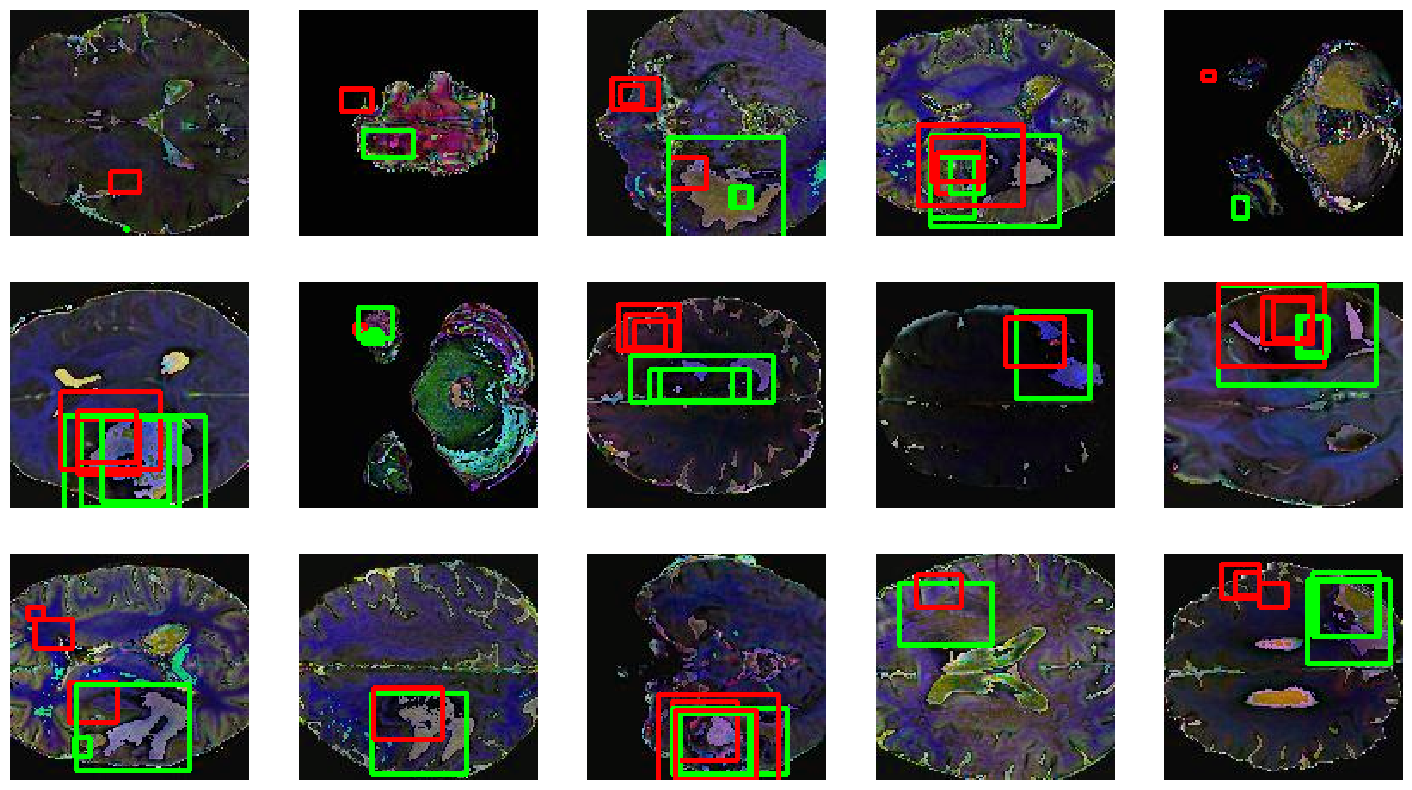

In [ ]:
# Green -> Ground Truth | Red -> Detection
cnn_detections(attributes=cnn_test_attributes, ground_truth=test_boxes, n=15, model=sandbox_cnn)

## **3.2. YOLOv8 Model**

- We're using the YOLOv8 detector model with a backbone pre-trained on COCO (large dataset for object detection, segmentation, ...);

- The optimizer only has the _global\_clipnorm_ parameter specified, a keras_cv recommendation for building object detection models (problems with vanishing
and exploding gradients destabilizing training process);

- For more information on keras_cv models click [here](https://keras.io/api/keras_cv/models/), and for information about optimizers in object detection click [here](https://keras.io/guides/keras_cv/object_detection_keras_cv/#optimizer);

- The default detection metric used to evaluate the model is CIoU.

In [12]:
from keras.optimizers import AdamW
from keras_cv.models  import (YOLOV8Backbone,
                              YOLOV8Detector)


# Strategy typically used for training on one machine with multiple GPUs.
stg = tf.distribute.MirroredStrategy()

with stg.scope():

    backbone = YOLOV8Backbone.from_preset('yolo_v8_xs_backbone_coco')

    yolo_model = YOLOV8Detector(num_classes=len(class_mapping),
                                bounding_box_format=BBOX_FORMAT,
                                backbone=backbone, fpn_depth=1)

    optimizer = AdamW(#learning_rate=0.0001, weight_decay=0.004,
                      global_clipnorm=10)

    yolo_model.compile(optimizer=optimizer, classification_loss='binary_crossentropy', box_loss='ciou')

### **3.2.1. Training Process**

- We're using several callbacks to optimize training:
    - **EarlyStopping**: Stops the training if after a number of epochs the model doesn't improve;

    - **ReduceLROnPlateau**: Reduces learning rate by a percentual if after a number of epochs the model doesn't improve;

    - **BackupAndRestore**: Saves training process to resume later in cause of abrupt interruption.

- We're using a custom callback to get other metrics (COCO), such as mAP;

- The number of epochs still need some study.

In [13]:
from keras_cv.metrics import BoxCOCOMetrics
from keras.callbacks  import Callback


class EvaluateCOCOMetricsCallback(Callback):

    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = BoxCOCOMetrics(bounding_box_format=BBOX_FORMAT, evaluate_freq=1e9)
        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):

        self.metrics.reset_state()

        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics['MaP']
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [14]:
from keras.callbacks import BackupAndRestore


# Decreases learning rate by half after each 3 epochs passed and no improvement was made
learning_rate_reduction = ReduceLROnPlateau(monitor='val_box_loss', factor=0.5,
                                            patience=3, verbose=1, mode='min',
                                            min_lr=0.00001)

# Stop training if after 5 epochs passed no improvement was made
early_stop = EarlyStopping(monitor='val_box_loss', patience=5, verbose=1,
                           mode='min', restore_best_weights=True)

# Saves the training state at the end of each epoch to restore later in case of abrupt interruption
if not isdir(f'{getcwd()}/backups'):
    mkdir(f'{getcwd()}/backups')
backup = BackupAndRestore(f'{getcwd()}/backups', save_freq='epoch')

In [15]:
# PS: Careful with RAM usage using backup and coco callbacks

use_coco = False

if use_coco:
    hist = yolo_model.fit(train_dataset, validation_data=valid_dataset, epochs=50,
                          callbacks=[learning_rate_reduction, early_stop,
                                     # backup,
                                     EvaluateCOCOMetricsCallback(valid_dataset, 'model.tf')
                                    ])
else:
    hist = yolo_model.fit(train_dataset, validation_data=valid_dataset, epochs=50,
                          callbacks=[learning_rate_reduction, early_stop
                                     #backup, EvaluateCOCOMetricsCallback(valid_dataset, 'model.tf'),
                                    ])

Epoch 1/50
441/441 [==============================] - 151s 164ms/step - loss: 13.9419 - box_loss: 2.3365 - class_loss: 11.6054 - val_loss: 11.9408 - val_box_loss: 4.0252 - val_class_loss: 7.9156 - lr: 0.0010
Epoch 2/50
441/441 [==============================] - 59s 124ms/step - loss: 2.6252 - box_loss: 1.9230 - class_loss: 0.7022 - val_loss: 4.1542 - val_box_loss: 2.8392 - val_class_loss: 1.3150 - lr: 0.0010
Epoch 3/50
441/441 [==============================] - 58s 123ms/step - loss: 2.3208 - box_loss: 1.7620 - class_loss: 0.5588 - val_loss: 4.2502 - val_box_loss: 3.0039 - val_class_loss: 1.2464 - lr: 0.0010
Epoch 4/50
441/441 [==============================] - 55s 120ms/step - loss: 2.1157 - box_loss: 1.6275 - class_loss: 0.4882 - val_loss: 4.1846 - val_box_loss: 3.0134 - val_class_loss: 1.1712 - lr: 0.0010
Epoch 5/50
441/441 [==============================] - ETA: 0s - loss: 1.9572 - box_loss: 1.5172 - class_loss: 0.4400
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00050000

In [16]:
model_path = f'{getcwd()}/yolo_tmp.keras'
yolo_model.save(model_path)

history_path = f'{getcwd()}/history_tmp.keras'
np.save(history_path, hist.history)

# **4. Analyzing Results**

In [ ]:
if 'hist' not in locals():
  hist = np.load(history_path, allow_pickle='TRUE').item()

## **Losses**

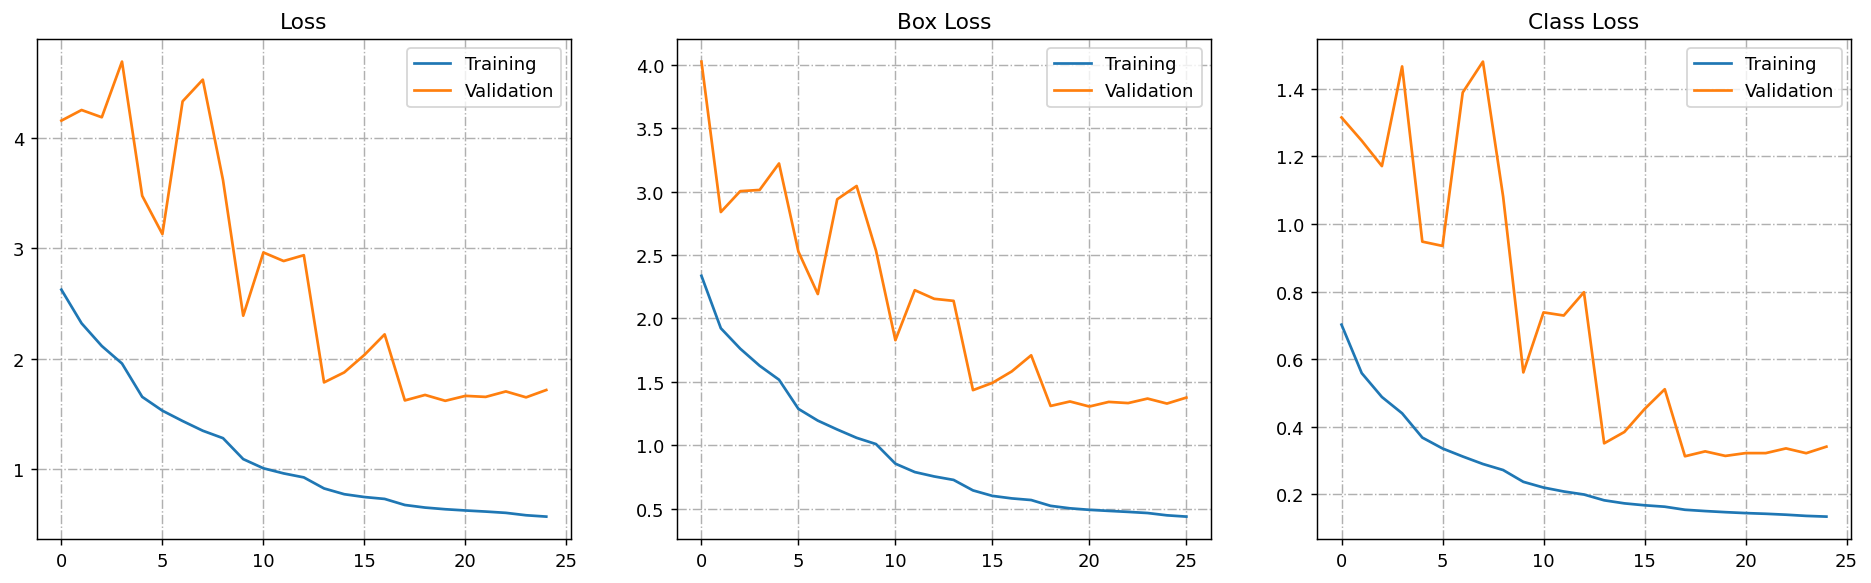

In [17]:
fig1, axs1 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs1[0].grid(linestyle='dashdot')
axs1[0].set_title('Loss')
axs1[0].plot(hist.history['loss'][1:])
axs1[0].plot(hist.history['val_loss'][1:])
axs1[0].legend(['Training', 'Validation'])

axs1[1].grid(linestyle='dashdot')
axs1[1].set_title('Box Loss')
axs1[1].plot(hist.history['box_loss'])
axs1[1].plot(hist.history['val_box_loss'])
axs1[1].legend(['Training', 'Validation'])

axs1[2].grid(linestyle='dashdot')
axs1[2].set_title('Class Loss')
axs1[2].plot(hist.history['class_loss'][1:])
axs1[2].plot(hist.history['val_class_loss'][1:])
axs1[2].legend(['Training', 'Validation'])

plt.savefig(f'{getcwd()}/plots/std_distribution.png', format='png')
plt.show()

## **Learning Rate**

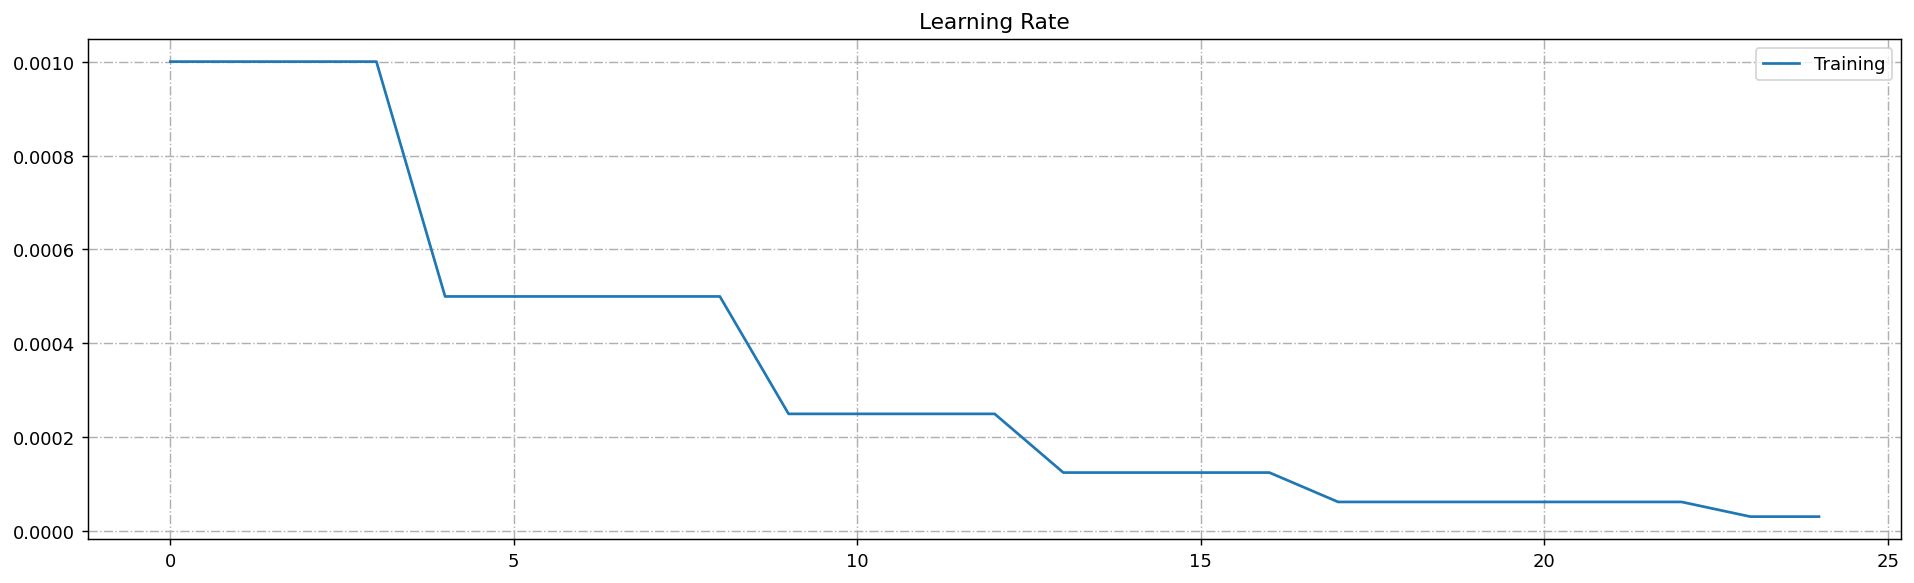

In [18]:
fig2, axs2 = plt.subplots(1, 1, figsize=(18, 5), dpi=130)

axs2.grid(linestyle='dashdot')
axs2.set_title('Learning Rate')
axs2.plot(hist.history['lr'][1:])
axs2.legend(['Training'])

plt.savefig(f'{getcwd()}/plots/learning_rate.png', format='png')
plt.show()

## **mAP**

In [ ]:
fig3, axs3 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs3[0].grid(linestyle='dashdot')
axs3[0].set_title('MaP')
axs3[0].plot(hist.history['MaP'][1:])
axs3[0].legend(['Training'])

axs3[1].grid(linestyle='dashdot')
axs3[1].set_title('MaP@[IoU=50]')
axs3[1].plot(hist.history['MaP'][1:])
axs3[1].legend(['Training'])

axs3[2].grid(linestyle='dashdot')
axs3[2].set_title('MaP@[IoU=75]')
axs3[2].plot(hist.history['MaP@[IoU=75]'][1:])
axs3[2].legend(['Training'])

plt.savefig(f'{getcwd()}/plots/map.png', format='png')
plt.show()

## **mAP - Area**

In [ ]:
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs4[0].grid(linestyle='dashdot')
axs4[0].set_title('MaP@[area=small]')
axs4[0].plot(hist.history['MaP@[area=small]'][1:])
axs4[0].legend(['Training'])

axs4[1].grid(linestyle='dashdot')
axs4[1].set_title('MaP@[area=medium]')
axs4[1].plot(hist.history['MaP@[area=medium]'][1:])
axs4[1].legend(['Training'])

axs4[2].grid(linestyle='dashdot')
axs4[2].set_title('MaP@[area=large]')
axs4[2].plot(hist.history['MaP@[area=large]'][1:])
axs4[2].legend(['Training'])

plt.savefig(f'{getcwd()}/plots/map_area.png', format='png')
plt.show()

## **Recall**

In [ ]:
fig5, axs5 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs5[0].grid(linestyle='dashdot')
axs5[0].set_title('Recall@[max_detections=1]')
axs5[0].plot(hist.history['Recall@[max_detections=1]'][1:])
axs5[0].legend(['Training'])

axs5[1].grid(linestyle='dashdot')
axs5[1].set_title('Recall@[max_detections=10]')
axs5[1].plot(hist.history['Recall@[max_detections=10]'][1:])
axs5[1].legend(['Training'])

axs5[2].grid(linestyle='dashdot')
axs5[2].set_title('Recall@[max_detections=100]')
axs5[2].plot(hist.history['Recall@[max_detections=100]'][1:])
axs5[2].legend(['Training'])

plt.savefig(f'{getcwd()}/plots/recall.png', format='png')
plt.show()

## **Recall - Area**

In [ ]:
fig6, axs6 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs6[0].grid(linestyle='dashdot')
axs6[0].set_title('Recall@[area=small1]')
axs6[0].plot(hist.history['Recall@[area=small]'][1:])
axs6[0].legend(['Training'])

axs6[1].grid(linestyle='dashdot')
axs6[1].set_title('Recall@[area=medium]')
axs6[1].plot(hist.history['Recall@[area=medium]'][1:])
axs6[1].legend(['Training'])

axs6[2].grid(linestyle='dashdot')
axs6[2].set_title('Recall@[area=large]')
axs6[2].plot(hist.history['Recall@[area=large]'][1:])
axs6[2].legend(['Training'])

plt.savefig(f'{getcwd()}/plots/recall_area.png', format='png')
plt.show()

## **4.1. Prediction Testing**

In [14]:
from keras.models import load_model

model_path = f'{getcwd()}/yolo_tmp.keras'

if 'yolo_model' not in locals():
    yolo_model = load_model(model_path)

In [12]:
def join_batches(batches):

    all_images = tf.concat([images for images, _ in batches], axis=0)
    all_classes = tf.concat([labels['classes'] for _, labels in batches], axis=0)
    all_boxes = tf.concat([labels['boxes'] for _, labels in batches], axis=0)

    return all_images, { 'classes': all_classes, 'boxes': all_boxes }

In [15]:
from keras_cv.bounding_box import to_ragged


test_instances, y_true = join_batches(batches=test_dataset.take(-1))
y_pred = yolo_model.predict(test_instances, verbose=0)
y_pred = to_ragged(y_pred)

In [13]:
def visualize_detections(images, y_true, y_pred, cols: int, rows: int,
                         bounding_box_format: str) -> None:

    print("############################# Padrão Ouro #############################")
    plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        true_color=(192, 57, 43),
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        rows=rows,
        cols=cols,
        show=True
        # class_mapping=class_mapping
    )

    print("############################# Previsto #############################")
    plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred,
        pred_color=(255, 235, 59),
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        rows=rows,
        cols=cols,
        show=True
        # class_mapping=class_mapping
    )

    print("############################# Sobreposição #############################")
    plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color=(192, 57, 43),
        pred_color=(255, 235, 59),
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        rows=rows,
        cols=cols,
        show=True
        # class_mapping=class_mapping
    )


def preview_labels(y_set, idx) -> dict:

    classes = tf.gather(y_set['classes'], idx)
    boxes = tf.gather(y_set['boxes'], idx)

    return { 'classes': classes, 'boxes': boxes }

############################# Padrão Ouro #############################


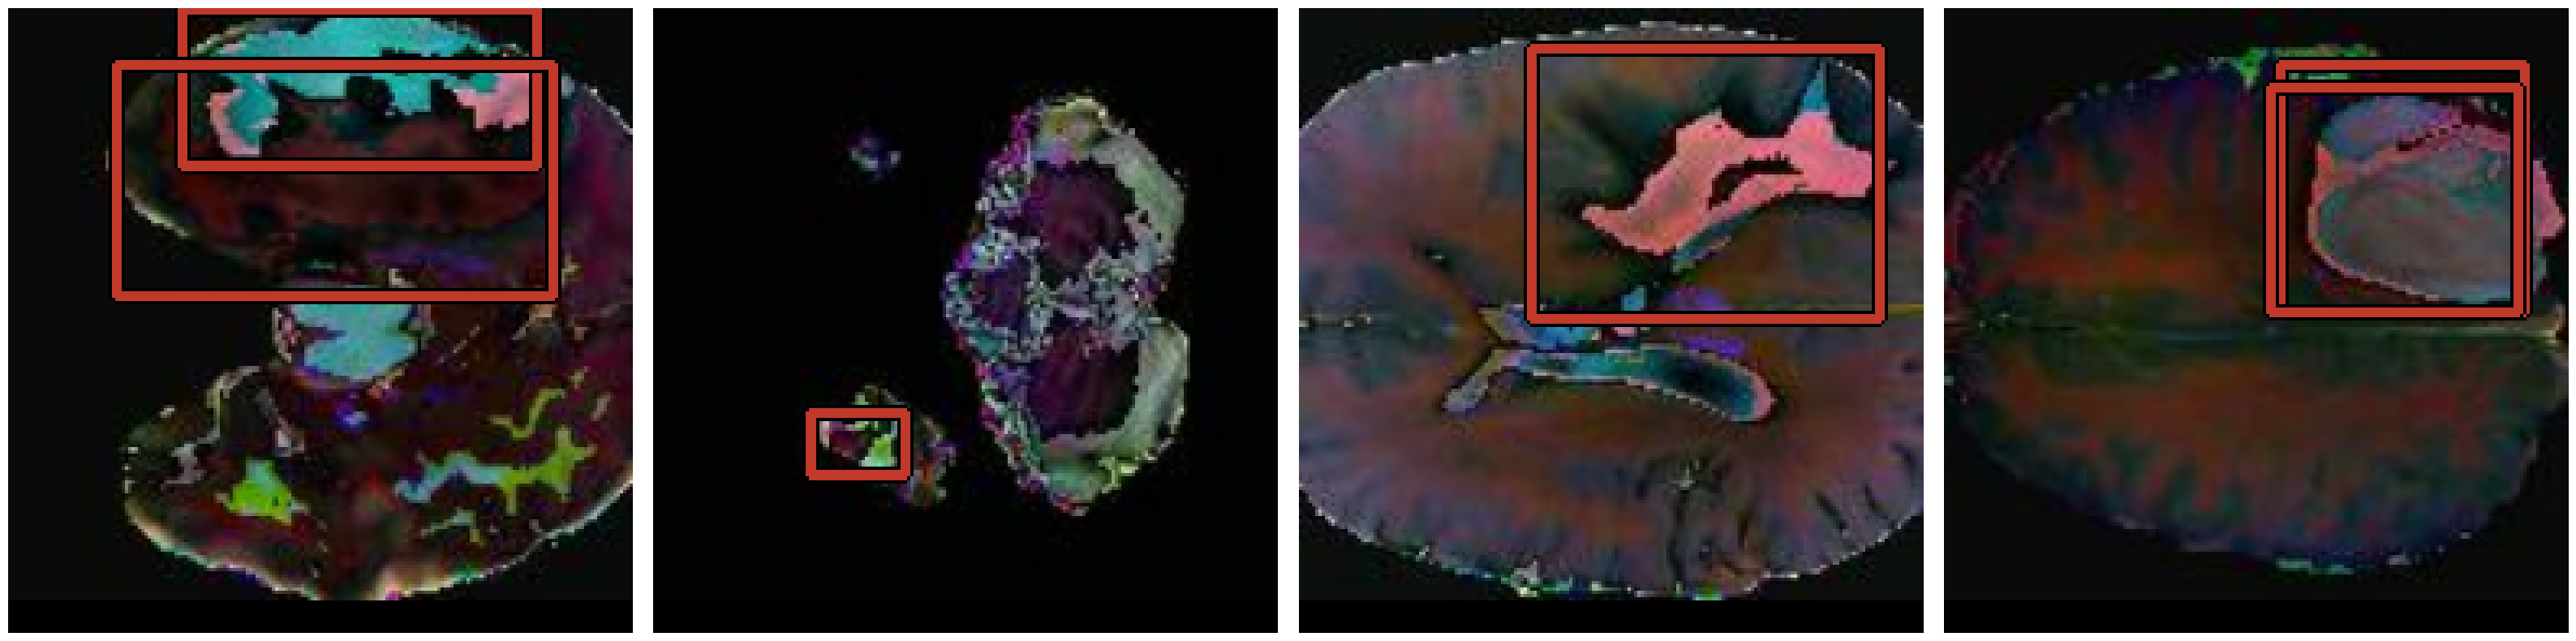

############################# Previsto #############################


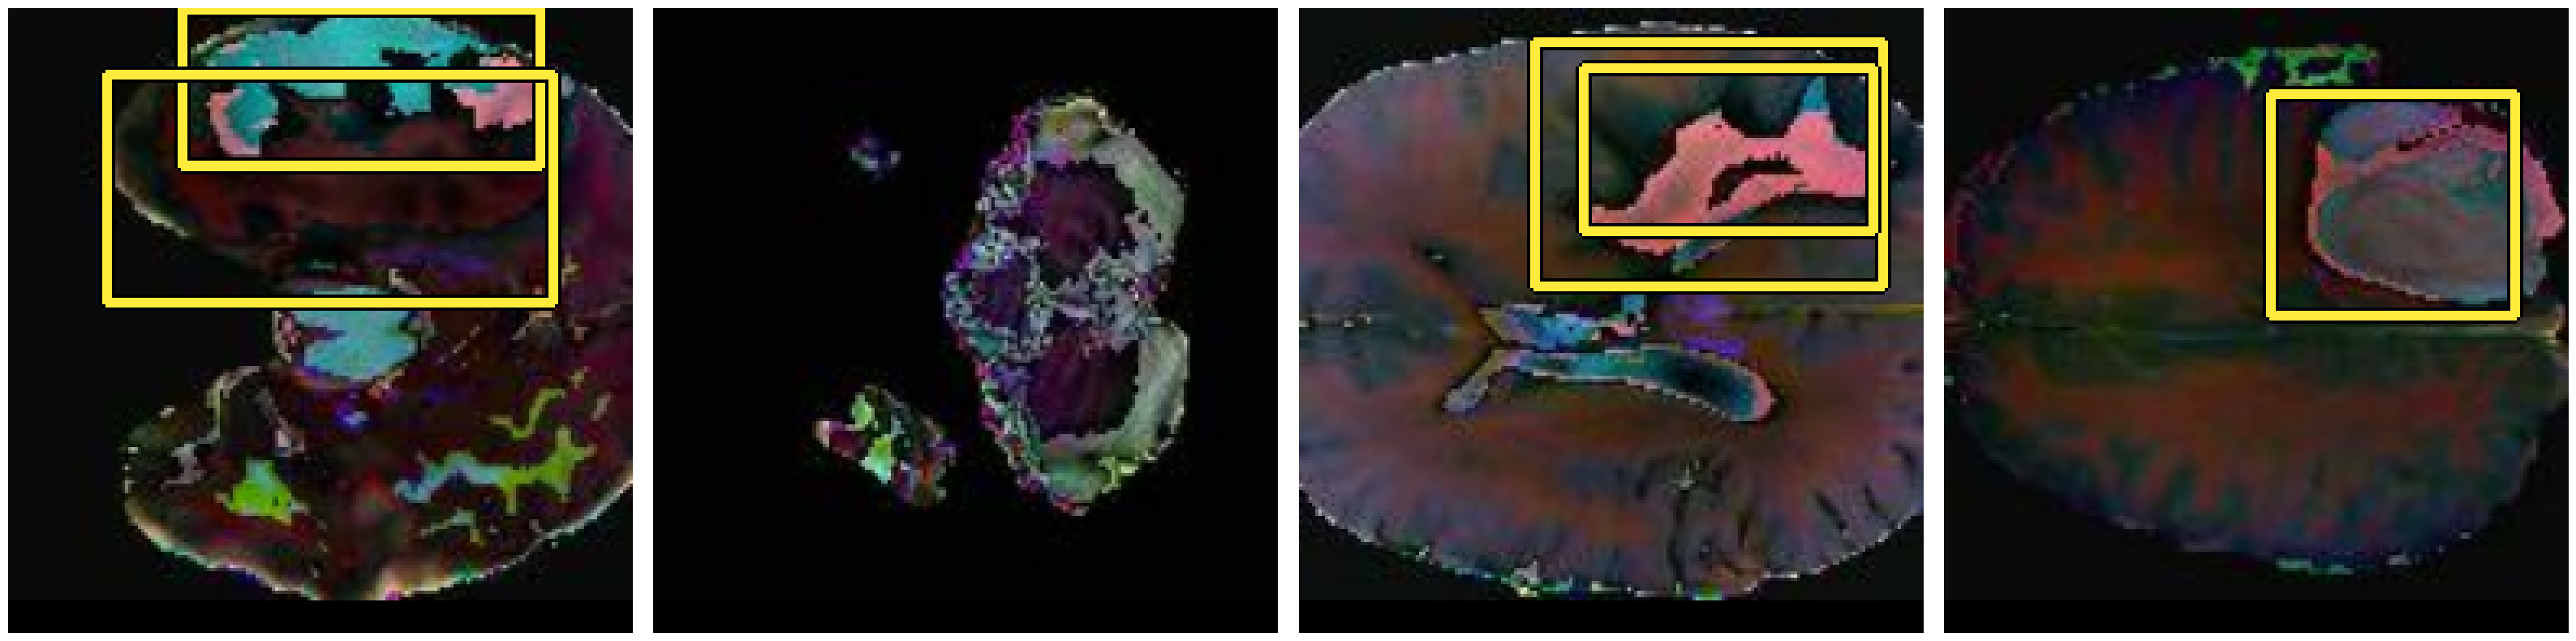

############################# Sobreposição #############################


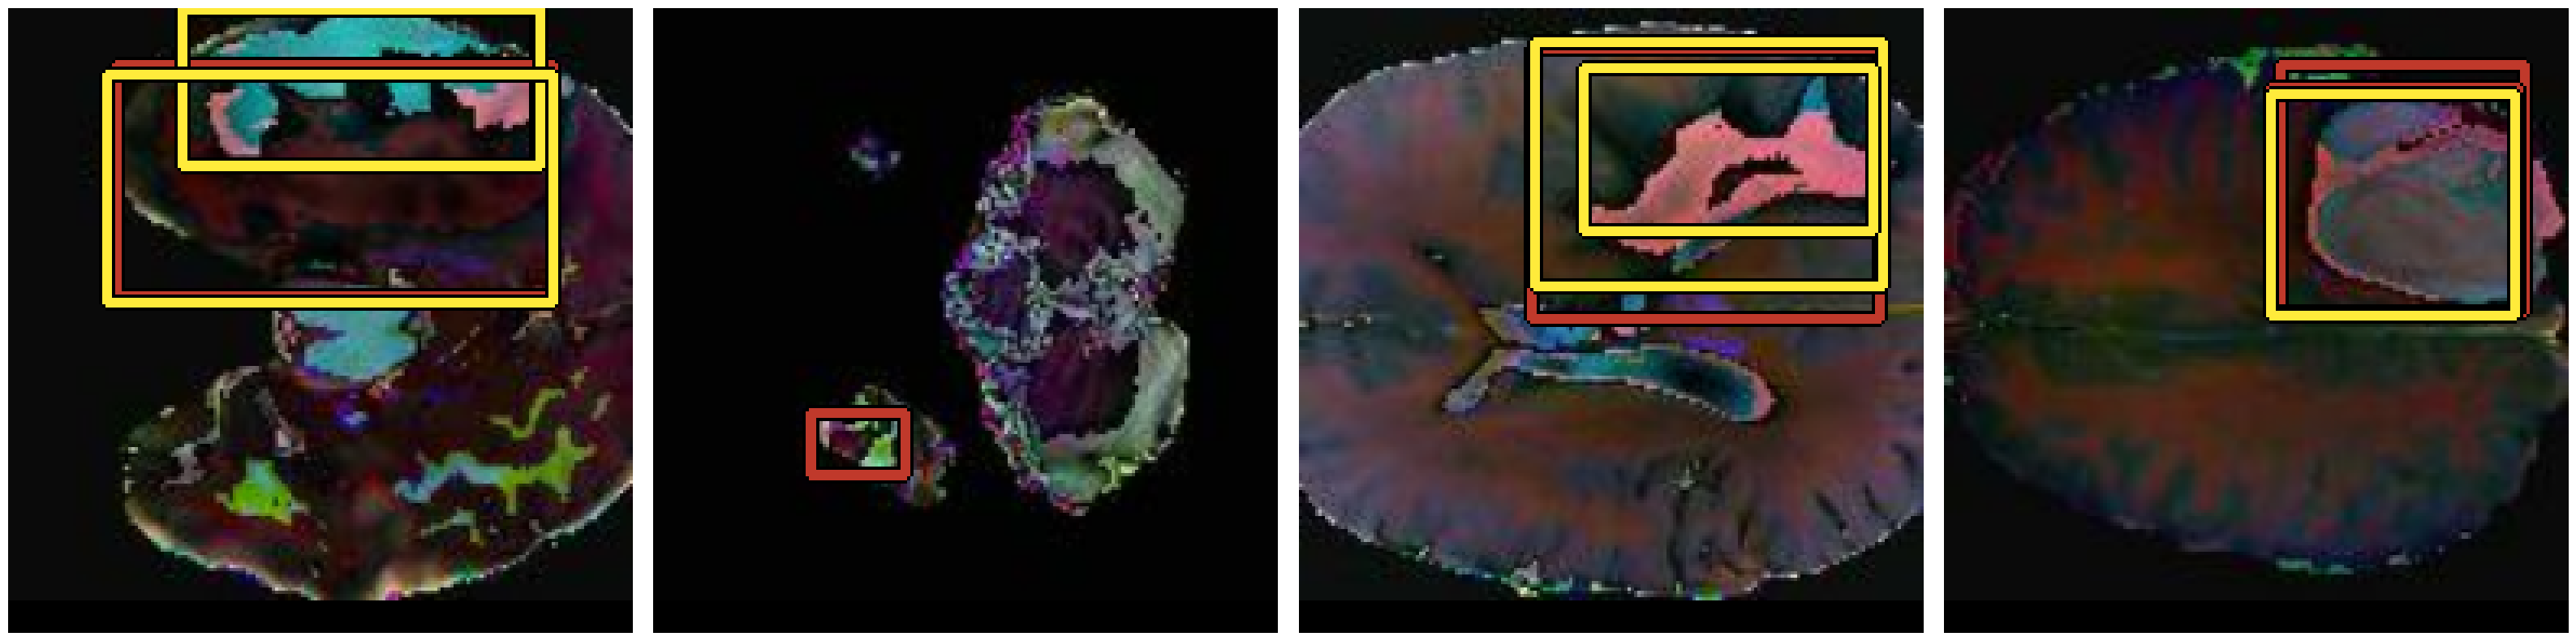

In [19]:
begin = 10
end = 20
idx = tf.constant(range(begin, end))

# Test dataset is scaled
preview_images = tf.gather(test_instances, idx)
preview_images = tf.cast(preview_images, tf.float32) * 255.0
preview_y_true = preview_labels(y_true, idx)
preview_y_pred = preview_labels(y_pred, idx)

visualize_detections(preview_images, preview_y_true, preview_y_pred,
                     cols=4, rows=1, bounding_box_format=BBOX_FORMAT)